# Import libraries

In [1]:
import numpy as np # to manipulate the arrays
import matplotlib.pyplot as plt # for visualization
from sklearn.linear_model import LinearRegression # to perform linear regression problem
from sklearn.linear_model import LogisticRegression # to perform binary classification problem
from sklearn.linear_model import SGDRegressor # SGD for regression problems
from sklearn.linear_model import Ridge, Lasso, ElasticNet # regularization term for linear regression
from sklearn.preprocessing import PolynomialFeatures # to transform the training data to fit polynomial problems
from sklearn.metrics import mean_squared_error # to evaluate the performance of a regression model
from sklearn.model_selection import train_test_split # split into training and test data
from sklearn.pipeline import Pipeline # pipeline for different steps of machine learning
from sklearn.base import clone # to clone the model
from sklearn.preprocessing import StandardScaler # to scale the data into standard distribution
from sklearn import datasets # load datasets which sklearn provided

import warnings # to ignore warnings
warnings.filterwarnings("ignore")

# Linear Regression

## The Normal Equation

In [2]:
# Generate random data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

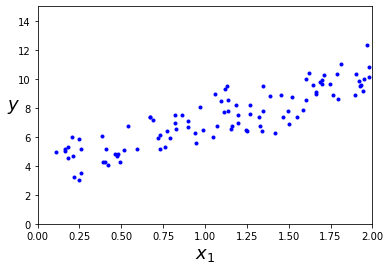

In [3]:
plt.plot(X, y, 'b.')
plt.xlabel("$x_1$", rotation=0, fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [4]:
# Calculate Normal Equation
X_b = np.c_[np.ones((100, 1)), X] # adding x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.86937528],
       [3.15404897]])

In [5]:
# Now let's evaluate some unseen data
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.86937528],
       [10.17747322]])

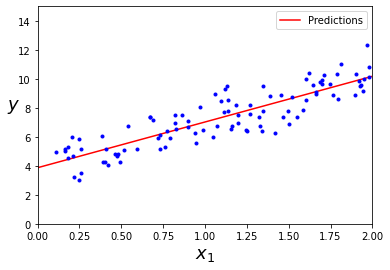

In [6]:
# Let's plot the model's prediction
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", rotation=0, fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.legend()
plt.show()

## Performing Linear Regression Using Scikit-Learn

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.86937528]), array([[3.15404897]]))

In [8]:
lin_reg.predict(X_new)

array([[ 3.86937528],
       [10.17747322]])

`LinearRegression` class is based on `np.linalg.lstsq()` function (which stands for "`least square`"), which we could call directly:

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.86937528],
       [3.15404897]])

In [10]:
s

array([15.40282157,  3.58992962])

# Gradient Descent

## Batch Gradient Descent

In [11]:
eta = 0.1 # learning rate
m = 100
n_iterations = 1000

theta = np.random.rand(2, 1) # random initialization

for iterations in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

theta

array([[3.86937528],
       [3.15404897]])

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

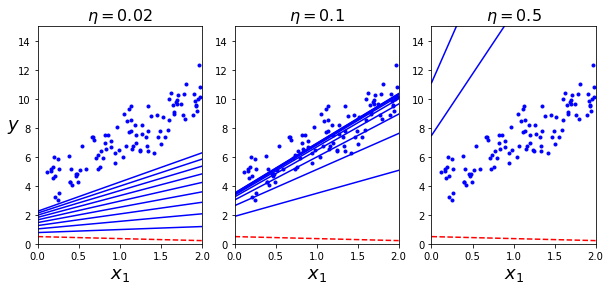

In [13]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)
plt.show()

## Stochastic Gradient Descent

In [14]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

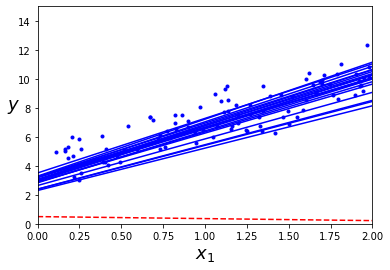

In [15]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 

plt.plot(X, y, "b.")                                
plt.xlabel("$x_1$", fontsize=18)                
plt.ylabel("$y$", rotation=0, fontsize=18)           
plt.axis([0, 2, 0, 15])                                                     
plt.show()    

In [16]:
# Using scikit-learn library
sgd_reg = SGDRegressor(max_iter=1000, penalty=None, tol=1e-3, eta0=0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [17]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.88493031]), array([3.18591169]))

# Mini-batch Gradient descent

In [18]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [19]:
theta

array([[3.8481064 ],
       [3.11761349]])

In [20]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

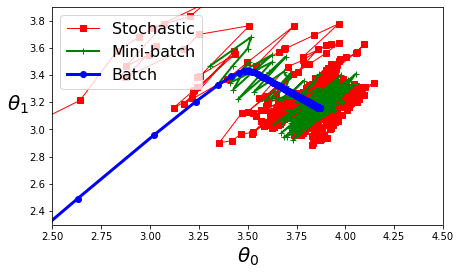

In [21]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

# Polynomial Regression

In [22]:
# Let's generate random instances based on a simple quadratic equation
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

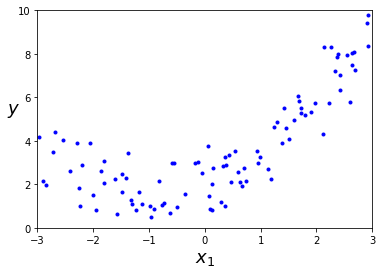

In [23]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-
Learn’s PolynomialFeatures class to transform our training data, adding
the square (second-degree polynomial) of each feature in the training set as a
new feature (in this case there is just one feature):

In [24]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly[0]

array([2.38942838, 5.709368  ])

In [25]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.9735233]), array([[0.95038538, 0.52577032]]))

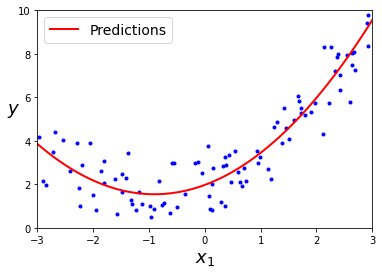

In [26]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

# Learning Curves

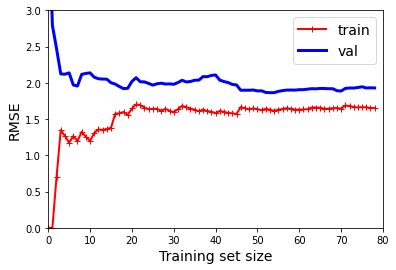

In [27]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)             

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                          
plt.show()                                     

Now let’s look at the learning curves of a 10th-degree polynomial model on
the same data:

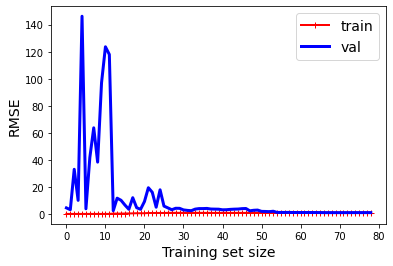

In [28]:
polynomial_regression = Pipeline([
            ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
            ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

# Ridge Regression

Performimg `Ridge Regression` with Scikit-Learn using a closed-
form solution.

In [29]:
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.13357033]])

Performing `Ridge Regression` with Scikit-Learn using Stochastic Gradient Descent.

In [30]:
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.12759575])

# Lasso Regression

In [31]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.09481859])

# Elastic Net

In [32]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.09373477])

# Early Stopping

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# prepare the data
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90,include_bias=False)),
        ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

In [34]:
best_epoch

107

Let's create a graph:

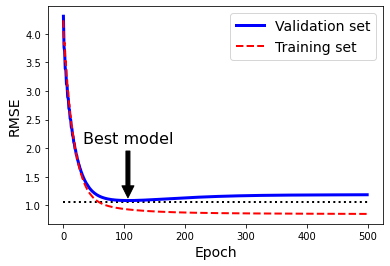

In [35]:


sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

# Logistic Regression
## Decision Boundaries

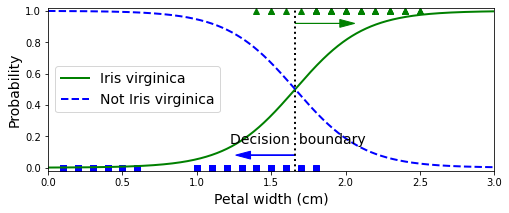

In [36]:
iris = datasets.load_iris()
X = iris['data'][:, 3:] # petal width
y = (iris['target'] == 2).astype('int') # 1 if Iris virginica, else 0
log_reg = LogisticRegression()
log_reg.fit(X, y)
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

# Softmax Regression

In [37]:
X = iris["data"][:, (2, 3)] # petal length and petal width
y = iris["target"]
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10) # where C is the regularization parameter for softmax loss function
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [38]:
y_pred = softmax_reg.predict([[5, 2]])
y_probas = softmax_reg.predict_proba([[5, 2]])
y_pred, y_probas

(array([2]), array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]]))

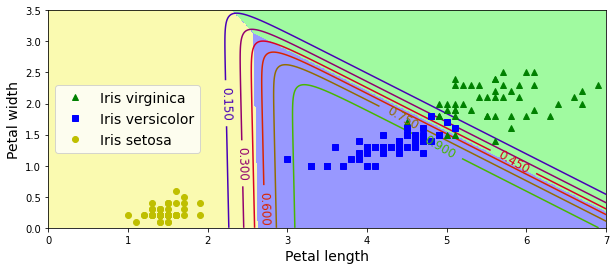

In [39]:
# Decision boundary for softmax regression classifier
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

# Batch Gradient Descent with early stopping for Softmax Regression

In [40]:
# Loading the data
X = iris["data"][:, (2, 3)] # petal length and petal width
y = iris["target"]

In [43]:
# Adding bias term for x0 = 1
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [44]:
# And let's set the random seed so the output of this exercise solution is reproducible:
np.random.seed(2042)

In [59]:
# split the dataset into training, validation and testing sets
test_size = 0.2
val_size = 0.2
len_of_dataset = len(X)

test_len = int(test_size * len_of_dataset)
val_len = int(val_size * len_of_dataset)
train_len = len_of_dataset - (test_len + val_len)

shuffle_dataset = np.random.permutation(len(X))
X_train = X_with_bias[shuffle_dataset[:train_len]]
y_train = y[shuffle_dataset[:train_len]]
X_valid =  X_with_bias[shuffle_dataset[train_len:-val_len]]
y_valid = y[shuffle_dataset[train_len:-val_len]]
X_test = X_with_bias[shuffle_dataset[-val_len:]]
y_test = y[shuffle_dataset[-val_len:]]

In [67]:
# convert the target value to one-hot for the purpose of cross entropy loss
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot

In [79]:
# Let create the target class probabilities matrix for the training set and the test set:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

In [80]:
# Now let's implement softmax function
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [92]:
# Let's define the number of inputs and outputs:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

In [96]:
# Now let's train the model
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.365418048249516
500 0.9077031473179582
1000 0.7139764165387328
1500 0.6055440744393542
2000 0.5372852446503984
2500 0.48983854091806217
3000 0.45441434047335255
3500 0.42659146982076024
4000 0.40392275991707627
4500 0.38494159025383806
5000 0.36871073255949


In [97]:
Theta

array([[ 2.74522664, -0.97201483, -3.09199818],
       [-1.85051277, -0.90118501, -1.17273338],
       [-2.05398519, -0.39805435,  1.67054794]])

In [98]:
#Let's make predictions for the validation set and check the accuracy score:

logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

In [99]:
# Now let's add a bit of l2 regularization
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
        loss = xentropy_loss + alpha * l2_loss
        print(iteration, loss)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 4.435507994243469
500 0.5213205350094917
1000 0.4948085525497623
1500 0.48727179031251755
2000 0.4845283420910476
2500 0.48344214448782724
3000 0.48299357834144246
3500 0.48280381439883724
4000 0.48272235228929333
4500 0.4826870595778916
5000 0.48267167919337506


In [101]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

In [102]:
# Now let's add early stopping.
eta = 0.1 
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1  # regularization hyperparameter
best_loss = np.infty

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, "early stopping!")
        break

0 1.53922696321646
500 0.6074097489903618
1000 0.5827579932826983
1500 0.5749244687733802
2000 0.571840141536208
2500 0.5705275279180879
3000 0.5699362765581412
3500 0.5696559594300674
4000 0.569516254239412
4500 0.5694431016505631
5000 0.5694029326959643


In [103]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9333333333333333

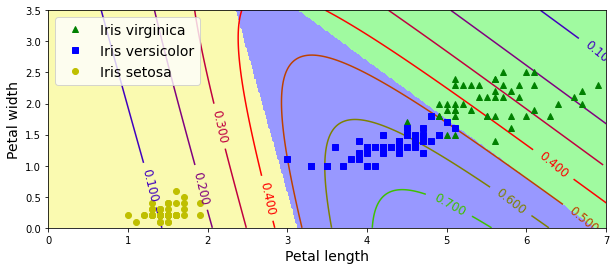

In [104]:
#Now let's plot the model's predictions on the whole dataset:

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [105]:
#And now let's measure the final model's accuracy on the test set:

logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0.9666666666666667